### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import query as q

In [2]:
# testing with NEOs
query = q.make_query(q_cutoff=1.3, a_cutoff_min=4.0, e_cutoff = 1.0)
print(query)

SELECT incl, q, e FROM dp03_catalogs_10yr.MPCORB as mpc
            WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) > 4.0;


In [3]:
# running the query
NEO_objects_table = q.run_query(query)

Job phase is COMPLETED
       incl                q                  e         
       deg                 AU                           
------------------ ------------------ ------------------
 31.09252999999999 1.2431035093273948 0.7084432623285193
 19.65134000000001 0.9203771729951332 0.9482300675541342
11.950449999999982 1.2044032778498057 0.7171247011872852
20.647300000000012 0.9577024708382867 0.9221009097705802
17.385910000000003 1.1049621973607813  0.779217861775766


In [4]:
a = q.calc_semimajor_axis(NEO_objects_table['q'], NEO_objects_table['e'])
NEO_objects_table['a'] = a
print(NEO_objects_table[0:5]) # print first few rows 

       incl                q                  e                  a         
       deg                 AU                                              
------------------ ------------------ ------------------ ------------------
 31.09252999999999 1.2431035093273948 0.7084432623285193  4.263676151871663
 19.65134000000001 0.9203771729951332 0.9482300675541342 17.778218543312622
11.950449999999982 1.2044032778498057 0.7171247011872852  4.257718093113579
20.647300000000012 0.9577024708382867 0.9221009097705802 12.294141921526524
17.385910000000003 1.1049621973607813  0.779217861775766  5.004762641797333


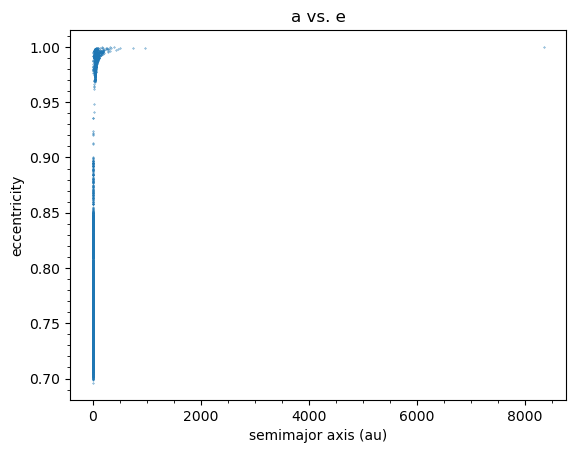

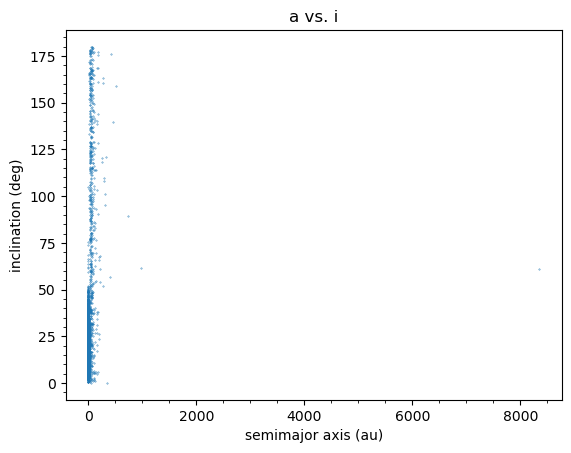

In [5]:
q.plot_data(NEO_objects_table)

In [6]:
q.type_counts(NEO_objects_table)

MBA Count: 0
NEO Count: 3049
TNO Count: 328
Centaur Count: 273
LPC Count: 326


### Joining Original Query with DiaSource

In [2]:
# joins together MPC 10 year dataset with the DiaSource dataset by ssObjectId
query = q.make_query(q_cutoff=1.3, a_cutoff_min=4.0, e_cutoff = 1.0, join = 'Diasource')
print(query)

SELECT incl, q, e ssObjectID, magTrueVband FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) > 4.0;


In [3]:
# run query
DiaSource_joined_table = q.run_query(query)

Job phase is COMPLETED
       incl                q              ssObjectID     magTrueVband
       deg                 AU                                        
------------------ ------------------ ------------------ ------------
20.142954773991445 0.9796930871750984 0.9800040893375994    23.838762
20.142954773991445 0.9796930871750984 0.9800040893375994    23.837643
20.142954773991445 0.9796930871750984 0.9800040893375994    23.828745
20.142954773991445 0.9796930871750984 0.9800040893375994     24.23662
20.142954773991445 0.9796930871750984 0.9800040893375994    23.837542


#### How many observations for each object? In what filters?

In [4]:
# turning the Astropy table into a pandas dataframe (mainly so I don't have to deal with masked columns)
df = DiaSource_joined_table.to_pandas()

# need to count observations for each unique object in SSO_id
print(df['ssObjectID'].value_counts())

ssObjectID
0.707879    318
0.993783    234
0.752818    214
0.990821    210
0.997276    204
           ... 
0.979033      9
0.995373      8
0.987605      8
0.985597      7
0.997862      7
Name: count, Length: 492, dtype: int64


                   incl           q
ssObjectID                         
0.700856    1874.070064   52.180418
0.705849     278.888508   41.224473
0.707879    4948.754102  374.835457
0.708443    2922.697820  116.851730
0.712495     444.499658   65.310857
...                 ...         ...
0.998798    2610.417946   10.584425
0.998863    1549.581962    8.713225
0.999100      58.559513    0.660424
0.999226    3818.338270    9.478273
0.999510    4751.188595   16.509193

[492 rows x 2 columns]


In [ ]:
# what filters? 

#### What is the average magnitude range? Does any object have an unusually large range?

In [24]:
service = get_tap_service("ssotap")
assert service is not None
results = service.search("SELECT column_name, datatype, description, "
                         "unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp03_catalogs_10yr.DiaSource'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure whe...,
1,ccdVisitId,int,Id of the ccdVisit where this diaSource was me...,
2,dec,double,Dec-coordinate of the center of this diaSource.,deg
3,decErr,float,Uncertainty of dec.,deg
4,decTrue,double,True (noiseless) declination of the simulated ...,
5,diaObjectId,long,Id of the diaObject this source was associated...,
6,diaSourceId,long,Unique id.,
7,mag,float,Magnitude. This is a placeholder and should be...,
8,magErr,float,Magnitude error. This is a placeholder and sho...,
9,magTrueVband,float,True (noiseless) V-band magnitude of the simul...,


In [28]:
results['description'][9]

np.str_('True (noiseless) V-band magnitude of the simulated diaSource')

In [5]:
# need to group by unique ssObjectID values
# create new dataframe to hold average of each group 

print(df.columns)

mag_data = df.groupby(['ssObjectID']).agg(
    mag_mean = ('magTrueVband', 'mean'))

print(mag_data)

Index(['incl', 'q', 'ssObjectID', 'magTrueVband'], dtype='object')
             mag_mean
ssObjectID           
0.700856    25.428816
0.705849    27.610319
0.707879    20.572180
0.708443    19.141516
0.712495    23.173910
...               ...
0.998798    20.653160
0.998863    21.580650
0.999100    21.859852
0.999226    21.619707
0.999510    19.845541

[492 rows x 1 columns]


#### Now need to look at the average range
For each object, need to find the average range? So, min and max for each observation?